## 2: Segmentation of Biomedical Images


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from time import time
import glob

np.random.seed(0)

In [2]:
import imageio.v2 as imageio

def load_warwick():

  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/image_*.png")):
    image = imageio.imread(image_path)
    train_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/label_*.png")):
    label = imageio.imread(label_path)
    train_labels.append(label)  

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/image_*.png")):
    image = imageio.imread(image_path)
    test_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/label_*.png")):
    label = imageio.imread(label_path)
    test_labels.append(label)

  X_train = torch.tensor(np.array(train_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_train = torch.tensor(np.array(train_labels), dtype=torch.long)/255
  X_test = torch.tensor(np.array(test_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_test = torch.tensor(np.array(test_labels), dtype=torch.long)/255

  return X_train, Y_train, X_test, Y_test
     


In [3]:
bz = 32
X_train, Y_train, X_test, Y_test = load_warwick()
# create dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bz, shuffle=False)

In [4]:
# look at the size of image and label
print(X_train.size())
print(Y_train.size())


torch.Size([85, 3, 128, 128])
torch.Size([85, 128, 128])


In [5]:


# Define the modified CNN architecture
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Add padding to preserve spatial dimensions
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Add padding to preserve spatial dimensions
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # Add padding to preserve spatial dimensions
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)  # Add padding to preserve spatial dimensions
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 1, 3, padding=1)  # Adjust output channels to 1
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        return x.squeeze()

# Create an instance of the modified CNN
model = ModifiedCNN()

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [6]:
def dice_coefficient(outputs, targets):
    eps = 1e-8
    intersection = torch.sum(abs(outputs) * abs(targets))
    union = torch.sum(outputs) + torch.sum(targets)
    dice = (2. * intersection) / abs(union + eps)
    return dice

def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_losses = []
    test_losses = []
    train_dice_scores = []
    test_dice_scores = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_dice = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calculate Dice score
            outputs = (outputs > 0.5).float()
            dice = dice_coefficient(outputs, labels)
            train_dice += dice.item()
        
        train_losses.append(train_loss / len(train_loader))
        train_dice_scores.append(train_dice / len(train_loader))
    
        model.eval()
        test_loss = 0
        test_dice = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, labels)
                test_loss += loss.item()

                # Calculate Dice score
                outputs = (outputs > 0.5).float()
                dice = dice_coefficient(outputs, labels)
                test_dice += dice.item()
            
            test_losses.append(test_loss / len(test_loader))
            test_dice_scores.append(test_dice / len(test_loader))
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Dice Score: {train_dice_scores[-1]:.4f}, Test Dice Score: {test_dice_scores[-1]:.4f}')
    total = time() - start
    plot_title = f'{model_name} - lr: {lr} - Total Time: {total//60:.2f}min {total%60:.2f}s, Epochs: {num_epochs}'
    training_curve_plot(plot_title,train_losses, test_losses, train_dice_scores, test_dice_scores)


In [7]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train dice: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test dice: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('dice', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('dice (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

Epoch 1/100, Train Loss: 1.7695, Test Loss: 0.7182, Train Dice Score: 0.2031, Test Dice Score: 0.2628
Epoch 2/100, Train Loss: 0.7626, Test Loss: 0.7505, Train Dice Score: 0.5373, Test Dice Score: 0.4321
Epoch 3/100, Train Loss: 0.7022, Test Loss: 0.6901, Train Dice Score: 0.2052, Test Dice Score: 0.0000
Epoch 4/100, Train Loss: 0.6929, Test Loss: 0.6855, Train Dice Score: 0.0000, Test Dice Score: 0.0015
Epoch 5/100, Train Loss: 0.6700, Test Loss: 0.6797, Train Dice Score: 0.0696, Test Dice Score: 0.2102
Epoch 6/100, Train Loss: 0.6463, Test Loss: 0.6691, Train Dice Score: 0.2948, Test Dice Score: 0.4954
Epoch 7/100, Train Loss: 0.6160, Test Loss: 0.6850, Train Dice Score: 0.5049, Test Dice Score: 0.5641
Epoch 8/100, Train Loss: 0.6086, Test Loss: 0.6696, Train Dice Score: 0.5627, Test Dice Score: 0.5543
Epoch 9/100, Train Loss: 0.5868, Test Loss: 0.6596, Train Dice Score: 0.5906, Test Dice Score: 0.4677
Epoch 10/100, Train Loss: 0.5659, Test Loss: 0.6435, Train Dice Score: 0.5932, Tes

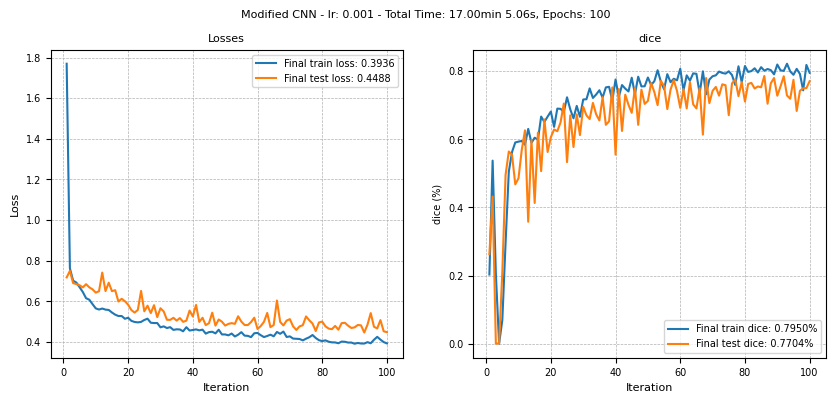

In [8]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModifiedCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_network(model, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='Modified CNN', lr=learning_rate)